# Librerie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from memory_profiler import profile
#import tensorflow as tf
import nltk
import sklearn

from transformers import RobertaTokenizer
from sacremoses import MosesTokenizer

import seaborn as sns
from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tokenizer.text_cleaning import clean_text
from tokenizer.bpe import BPEPipeline, BPE
from tokenizer.MosesTokenizer import MosesTokenizationPipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\keita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from tokenizer.bpe import BpeRobertaPipeline
from tokenizer.XLNtokenizer import XLNetTokenization
from tokenizer.morfessor_tokenizator import MorfessorTokenizationPipeline

In [3]:
def apply_bpe_to_series(series):
    return series.apply(bpe_pipeline.transform)

In [4]:
%load_ext memory_profiler

## Importazione dataset

In [5]:
train_set = pd.read_csv('dataset/train.csv')
test_set = pd.read_csv("dataset/test.csv")

## Analisi preliminari 

In [6]:
train_set.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [7]:
target_category = train_set['Class Index'].unique()
print(target_category)

[3 4 2 1]


In [8]:
category = train_set[["Class Index"]].drop_duplicates().sort_values('Class Index')
category

,Class Index
492,1
448,2
0,3
78,4


In [9]:
train_set.groupby('Class Index').Description.count()

Class Index
1    30000
2    30000
3    30000
4    30000
Name: Description, dtype: int64

<AxesSubplot:xlabel='Class Index'>

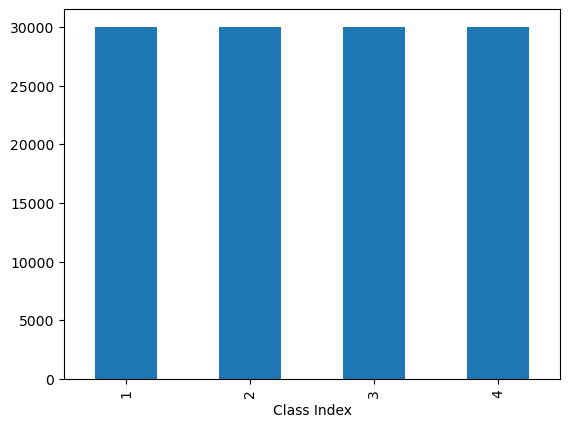

In [10]:
train_set.groupby('Class Index').Description.count().plot.bar(ylim=0)

In [11]:
train_set

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


## White space 

In [12]:
#WHITE

def list_to_string(df, source_column, new_column):
    """
    Converte una lista di parole in una colonna del DataFrame in una stringa unica.
    
    Args:
    df (pandas.DataFrame): DataFrame che contiene la colonna di liste di parole.
    source_column (str): Nome della colonna da cui prendere le liste di parole.
    new_column (str): Nome della nuova colonna con il testo convertito in stringa.

    Returns:
    pandas.DataFrame: DataFrame con la nuova colonna aggiunta.
    """
    # Verifica che la colonna esista nel DataFrame
    if source_column not in df.columns:
        raise ValueError(f"La colonna {source_column} non esiste nel DataFrame fornito.")

    # Converte ogni lista di parole in una stringa unica
    df[new_column] = df[source_column].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

    return df

# Applica la funzione al tuo DataFrame
clean_func = clean_text('Description')
train_set['cleaned_text'] = train_set['Description'].apply(clean_func)
train_set = list_to_string(train_set, 'cleaned_text', 'text_w')
test_set['cleaned_text'] = test_set['Description'].apply(clean_func)
test_set=list_to_string(test_set, 'cleaned_text', 'text_w')

# Visualizza le prime righe per vedere il risultato
# print(test_set['text_w'].head())

## Analisi complessa 

In [13]:
%memit list_to_string(train_set, 'cleaned_text', 'text_w')

peak memory: 619.04 MiB, increment: 0.96 MiB


In [16]:
%timeit list_to_string(train_set, 'cleaned_text', 'text_w')

68.6 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Naive bayes 

In [14]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_set['text_w'],train_set['Class Index'])

test_predict = nb.predict(test_set['text_w'])

train_accuracy = round(nb.score(train_set['text_w'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
# Supponiamo che target_category sia attualmente un array numerico o una lista di numeri
# Convertilo in una lista di stringhe
target_category = [str(name) for name in target_category]

# Ora usa questa lista modificata nel classification_report
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

Naive Bayes Train Accuracy Score : 91% 
Naive Bayes Test Accuracy Score  : 89% 

              precision    recall  f1-score   support

           3       0.89      0.91      0.90      1861
           4       0.97      0.95      0.96      1943
           2       0.85      0.86      0.85      1887
           1       0.87      0.86      0.86      1909

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



## Matrice di confusione 

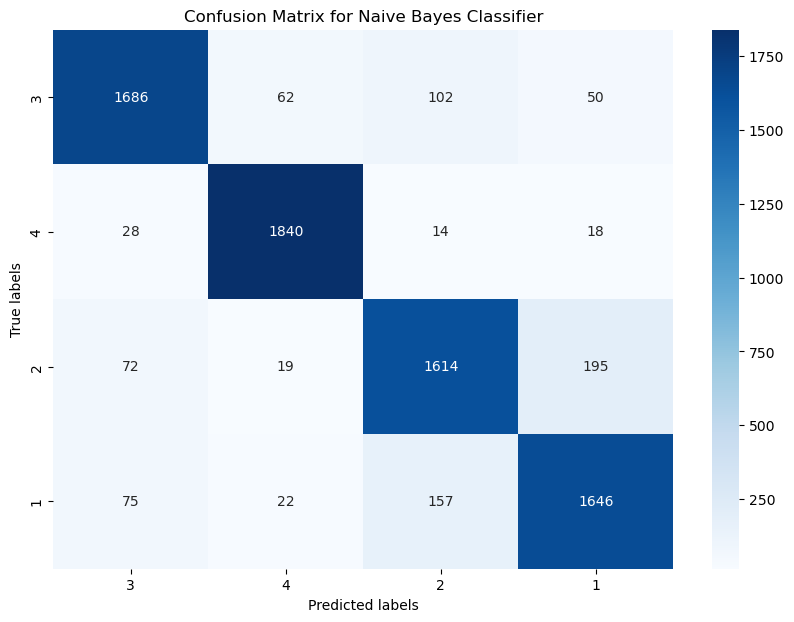

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Per una visualizzazione più attraente della matrice di confusione

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(test_set['Class Index'], test_predict)

# Usa Seaborn per creare una heatmap della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=target_category, yticklabels=target_category)

# Aggiungi titoli e etichette
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.show()


## Decision tree 

In [17]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier(random_state=42)),
               ])

dt.fit(train_set['text_w'],train_set['Class Index'])

test_predict = dt.predict(test_set['text_w'])

train_accuracy = round(dt.score(train_set['text_w'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 81% 

              precision    recall  f1-score   support

           3       0.82      0.80      0.81      1930
           4       0.89      0.87      0.88      1949
           2       0.76      0.77      0.76      1895
           1       0.75      0.78      0.76      1826

    accuracy                           0.81      7600
   macro avg       0.81      0.80      0.80      7600
weighted avg       0.81      0.81      0.81      7600



## Random forest 

In [ ]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100, random_state=42)),
               ])

rfc.fit(train_set['text_w'],train_set['Class Index'])

test_predict = rfc.predict(test_set['text_w'])

train_accuracy = round(rfc.score(train_set['text_w'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)

print("Random Forest Train Accuracy Score : {}% ".format(train_accuracy ))
print("Random Forest Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

## BPE 

In [50]:
#Addestro tokenizzatore
#corpus = train_set['Title']

#vocab_size = 1000

#bpe_pipeline = BPEPipeline(vocab_size)
#bpe_pipeline.fit(corpus)

#test_set['cleaned_text'] = test_set['Description'].apply(clean_func)
#test_set.head()

#test_set['Text_BPE'] = apply_bpe_to_series(test_set['cleaned_text'])
#test_set['Text_BPE'].head()

#test_set['Text_BPE'] = test_set['Text_BPE'].apply(lambda x: ' '.join(x))

## Analisi complessa 

In [ ]:
%memit apply_bpe_to_series(test_set['cleaned_text'])

In [ ]:
%timeit apply_bpe_to_series(test_set['cleaned_text'])

In [18]:
# Per questioni di comodità si importano i dataset con la tokenizzazione bpe già effettuata
train_set_bpe = pd.read_csv('dataset/train_set_bpe.csv')
test_set_bpe = pd.read_csv("dataset/test_set_bpe.csv")
test_set_bpe.head()

,Class Index,Title,Description,cleaned_text,Text_BPE,Text_BPE1
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,unions representing workers turner newall say ...,"['un', 'ions', 'Ġre', 'p', 'res', 'ent', 'ing'...",un ions Ġre p res ent ing Ġw ork ers Ġt urn er...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",space com toronto canada second team rocketeer...,"['s', 'p', 'ace', 'Ġc', 'om', 'Ġt', 'or', 'on'...",s p ace Ġc om Ġt or on to Ġc anad a Ġs econd Ġ...
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,ap company founded chemistry researcher univer...,"['ap', 'Ġcomp', 'an', 'y', 'Ġf', 'ound', 'ed',...",ap Ġcomp an y Ġf ound ed Ġc he m ist ry Ġres e...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,ap barely dawn mike fitzpatrick starts shift b...,"['ap', 'Ġb', 'ar', 'ely', 'Ġd', 'aw', 'n', 'Ġm...",ap Ġb ar ely Ġd aw n Ġm i ke Ġf it z p at ric ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,ap southern california smog fighting agency we...,"['ap', 'Ġs', 'out', 'her', 'n', 'Ġc', 'al', 'i...",ap Ġs out her n Ġc al if orn ia Ġs m og Ġf igh...


# Naive Bayes

In [54]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_set_bpe['Text_BPE1'],train_set_bpe['Class Index'])

test_predict_bpe = nb.predict(test_set_bpe['Text_BPE1'])

train_accuracy = round(nb.score(train_set_bpe['Text_BPE1'],train_set_bpe['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set_bpe['Class Index'])*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
# Supponiamo che target_category sia attualmente un array numerico o una lista di numeri
# Convertilo in una lista di stringhe
target_category = [str(name) for name in target_category]

# Ora usa questa lista modificata nel classification_report
print(classification_report(test_predict, test_set_bpe['Class Index'], target_names=target_category))


Naive Bayes Train Accuracy Score : 80% 
Naive Bayes Test Accuracy Score  : 80% 

              precision    recall  f1-score   support

           3       0.81      0.83      0.82      1849
           4       0.90      0.83      0.86      2068
           2       0.73      0.78      0.75      1784
           1       0.75      0.75      0.75      1899

    accuracy                           0.80      7600
   macro avg       0.80      0.80      0.80      7600
weighted avg       0.80      0.80      0.80      7600



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Per una visualizzazione più attraente della matrice di confusione

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(test_set_bpe['Class Index'], test_predict_bpe)

# Usa Seaborn per creare una heatmap della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=target_category, yticklabels=target_category)

# Aggiungi titoli e etichette
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.show()

## Decision tree

In [19]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier(random_state=42)),
               ])

dt.fit(train_set_bpe['Text_BPE1'],train_set_bpe['Class Index'])

test_predict = dt.predict(test_set_bpe['Text_BPE1'])

train_accuracy = round(dt.score(train_set_bpe['Text_BPE1'],train_set_bpe['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set_bpe['Class Index'])*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set_bpe['Class Index'], target_names=target_category))

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 70% 

              precision    recall  f1-score   support

           3       0.73      0.72      0.72      1940
           4       0.75      0.77      0.76      1866
           2       0.64      0.65      0.65      1864
           1       0.67      0.65      0.66      1930

    accuracy                           0.70      7600
   macro avg       0.70      0.70      0.70      7600
weighted avg       0.70      0.70      0.70      7600



## Random forest

In [56]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100, random_state=42)),
               ])

rfc.fit(train_set_bpe['Text_BPE1'],train_set_bpe['Class Index'])

test_predict = rfc.predict(test_set_bpe['Text_BPE1'])

train_accuracy = round(rfc.score(train_set_bpe['Text_BPE1'],train_set_bpe['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set_bpe['Class Index'])*100)

print("Random Forest Train Accuracy Score : {}% ".format(train_accuracy ))
print("Random Forest Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set_bpe['Class Index'], target_names=target_category))

K-Nearest Neighbour Train Accuracy Score : 100% 
K-Nearest Neighbour Test Accuracy Score  : 83% 

              precision    recall  f1-score   support

           3       0.82      0.86      0.84      1813
           4       0.92      0.85      0.88      2073
           2       0.76      0.83      0.79      1755
           1       0.80      0.78      0.79      1959

    accuracy                           0.83      7600
   macro avg       0.83      0.83      0.83      7600
weighted avg       0.83      0.83      0.83      7600



# BPE Roberta

In [20]:
# Applicazione metodo bpe Roberta
pipeline = BpeRobertaPipeline()
train_set['Text_BPER'] = pipeline.apply_pipeline(train_set, 'cleaned_text')
test_set['Text_BPER']=pipeline.apply_pipeline(test_set, 'cleaned_text')

## Analisi complessa 

In [ ]:
%memit pipeline.apply_pipeline(train_set, 'cleaned_text')

In [ ]:
%timeit pipeline.apply_pipeline(train_set, 'cleaned_text')

## Naive Bayes

In [64]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_set['Text_BPER'],train_set['Class Index'])

test_predict_bpe_roberta = nb.predict(test_set['Text_BPER'])

train_accuracy = round(nb.score(train_set['Text_BPER'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
# Supponiamo che target_category sia attualmente un array numerico o una lista di numeri
# Convertilo in una lista di stringhe
target_category = [str(name) for name in target_category]

# Ora usa questa lista modificata nel classification_report
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))


Naive Bayes Train Accuracy Score : 90% 
Naive Bayes Test Accuracy Score  : 89% 

              precision    recall  f1-score   support

           3       0.88      0.91      0.89      1851
           4       0.97      0.92      0.95      1993
           2       0.84      0.86      0.85      1857
           1       0.86      0.86      0.86      1899

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Per una visualizzazione più attraente della matrice di confusione

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(test_set_bpe['Class Index'], test_predict_bpe_roberta)

# Usa Seaborn per creare una heatmap della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=target_category, yticklabels=target_category)

# Aggiungi titoli e etichette
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.show()

## Decision tree

In [21]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier(random_state=42)),
               ])

dt.fit(train_set['Text_BPER'],train_set['Class Index'])

test_predict = dt.predict(test_set['Text_BPER'])

train_accuracy = round(dt.score(train_set['Text_BPER'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 79% 

              precision    recall  f1-score   support

           3       0.81      0.78      0.79      1963
           4       0.87      0.86      0.86      1921
           2       0.74      0.75      0.75      1876
           1       0.75      0.78      0.76      1840

    accuracy                           0.79      7600
   macro avg       0.79      0.79      0.79      7600
weighted avg       0.79      0.79      0.79      7600



## Random Forest

In [67]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100, random_state=42)),
               ])

rfc.fit(train_set['Text_BPER'],train_set['Class Index'])

test_predict = rfc.predict(test_set['Text_BPER'])

train_accuracy = round(rfc.score(train_set['Text_BPER'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)

print("Random Forest Train Accuracy Score : {}% ".format(train_accuracy ))
print("Random Forest Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

K-Nearest Neighbour Train Accuracy Score : 100% 
K-Nearest Neighbour Test Accuracy Score  : 88% 

              precision    recall  f1-score   support

           3       0.89      0.90      0.89      1879
           4       0.97      0.91      0.94      2021
           2       0.83      0.86      0.84      1834
           1       0.85      0.86      0.86      1866

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.89      0.88      0.88      7600



## XLN

In [14]:
clean_func = clean_text('Description')
train_set['cleaned_text'] = train_set['Description'].apply(clean_func)
train_set.head()
test_set['cleaned_text'] = test_set['Description'].apply(clean_func)

In [15]:
# Creazione della pipeline
pipeline = Pipeline([
    ('xlnet_tokenization', XLNetTokenization())])

# Esempio di utilizzo
train_set = pd.read_csv('dataset/train_set_bpe.csv')
test_set = pd.read_csv("dataset/test_set_bpe.csv")

train_set['XLN'] = pipeline.fit_transform(train_set['cleaned_text'])
test_set['XLN'] = pipeline.fit_transform(test_set['cleaned_text'])

#rimozione liste
train_set['XLN'] = train_set['XLN'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)
test_set['XLN'] = test_set['XLN'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

## Analisi complessa 

In [ ]:
%memit pipeline.fit_transform(train_set['cleaned_text'])

In [ ]:
%timeit pipeline.fit_transform(train_set['cleaned_text'])

# Naive bayes

In [15]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_set['XLN'],train_set['Class Index'])

test_predict = nb.predict(test_set['XLN'])

train_accuracy = round(nb.score(train_set['XLN'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
# Supponiamo che target_category sia attualmente un array numerico o una lista di numeri
# Convertilo in una lista di stringhe
target_category = [str(name) for name in target_category]

# Ora usa questa lista modificata nel classification_report
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))


Naive Bayes Train Accuracy Score : 90% 
Naive Bayes Test Accuracy Score  : 88% 

              precision    recall  f1-score   support

           3       0.88      0.91      0.89      1839
           4       0.97      0.92      0.94      1989
           2       0.83      0.85      0.84      1859
           1       0.85      0.85      0.85      1913

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



## Decision tree

In [16]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier(random_state=42)),
               ])

dt.fit(train_set['XLN'],train_set['Class Index'])

test_predict = dt.predict(test_set['XLN'])

train_accuracy = round(dt.score(train_set['XLN'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 77% 

              precision    recall  f1-score   support

           3       0.78      0.78      0.78      1914
           4       0.85      0.84      0.85      1918
           2       0.72      0.73      0.73      1865
           1       0.74      0.74      0.74      1903

    accuracy                           0.77      7600
   macro avg       0.77      0.77      0.77      7600
weighted avg       0.77      0.77      0.77      7600



## Random forest

In [19]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100, random_state=42)),
               ])

rfc.fit(train_set['XLN'],train_set['Class Index'])

test_predict = rfc.predict(test_set['XLN'])

train_accuracy = round(rfc.score(train_set['XLN'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)

print("Random Forest Train Accuracy Score : {}% ".format(train_accuracy ))
print("Random Forest Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

Random Forest Train Accuracy Score : 100% 
Random Forest Test Accuracy Score  : 89% 

              precision    recall  f1-score   support

           3       0.89      0.91      0.90      1842
           4       0.97      0.92      0.94      2012
           2       0.83      0.86      0.85      1847
           1       0.86      0.86      0.86      1899

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



# Moses

In [16]:
pipeline = MosesTokenizationPipeline('en')

# Applicare la tokenizzazione
train_set['Moses'] = pipeline.tokenize_column(train_set, 'cleaned_text')
test_set['Moses'] = pipeline.tokenize_column(test_set, 'cleaned_text')

stdbuf was not found; communication with perl may hang due to stdio buffering.


## Analisi complessa 

In [ ]:
%memit pipeline.tokenize_column(train_set, 'cleaned_text')

In [ ]:
%timeit pipeline.tokenize_column(train_set, 'cleaned_text')

## Naive Bayes

In [25]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_set['Moses'],train_set['Class Index'])

test_predict = nb.predict(test_set['Moses'])

train_accuracy = round(nb.score(train_set['Moses'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
# Supponiamo che target_category sia attualmente un array numerico o una lista di numeri
# Convertilo in una lista di stringhe
target_category = [str(name) for name in target_category]

# Ora usa questa lista modificata nel classification_report
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

Naive Bayes Train Accuracy Score : 91% 
Naive Bayes Test Accuracy Score  : 89% 

              precision    recall  f1-score   support

           3       0.89      0.91      0.90      1861
           4       0.97      0.95      0.96      1943
           2       0.85      0.86      0.85      1887
           1       0.87      0.86      0.86      1909

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



## Decision Tree

In [ ]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier(random_state=42)),
               ])

dt.fit(train_set['Moses'],train_set['Class Index'])

test_predict = dt.predict(test_set['Moses'])

train_accuracy = round(dt.score(train_set['Moses'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

## Random Forest

In [ ]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100, random_state=42)),
               ])

rfc.fit(train_set['Moses'],train_set['Class Index'])

test_predict = rfc.predict(test_set['Moses'])

train_accuracy = round(rfc.score(train_set['Moses'],train_set['Class Index'])*100)
test_accuracy =round(accuracy_score(test_predict, test_set['Class Index'])*100)

print("Random Forest Train Accuracy Score : {}% ".format(train_accuracy ))
print("Random Forest Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, test_set['Class Index'], target_names=target_category))

# Morfessor 

In [34]:
pipeline = MorfessorTokenizationPipeline('model/model.bin')
train_set['MorfessorTokens'] = train_set['cleaned_text'].apply(pipeline.tokenize)

KeyboardInterrupt: 

# Grafici per analisi complessa

In [23]:
tokenizer = pd.DataFrame({
    "Tokenizzatore": ["White Space", "BPE", "BPE Roberta", "XLN", "Moses"],
    "Tempo di Esecuzione (ms)": [68.6, 52.3, 74.1, 74.1, 74.1],
    "Incremento Memoria (MiB)": [0.85, 1.20, 0.95, 0.95, 0.95]
})

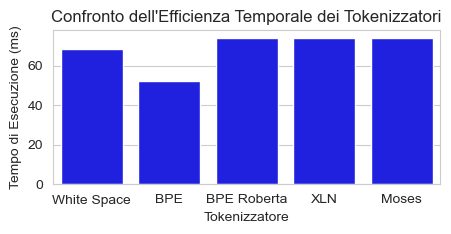

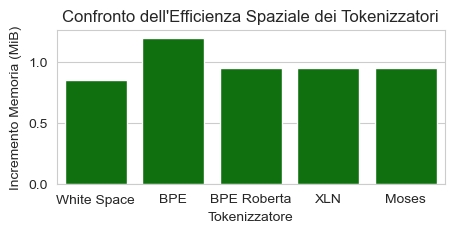

In [27]:
sns.set_style("whitegrid")

# Grafico per l'analisi temporale
plt.figure(figsize=(5, 2))
tempo_plot = sns.barplot(x="Tokenizzatore", y="Tempo di Esecuzione (ms)", data=tokenizer, color="blue")
tempo_plot.set_title('Confronto dell\'Efficienza Temporale dei Tokenizzatori')
#plt.savefig('analisi_temporale.png')
plt.show()

# Grafico per l'analisi spaziale
plt.figure(figsize=(5, 2))
memoria_plot = sns.barplot(x="Tokenizzatore", y="Incremento Memoria (MiB)", data=tokenizer, color="green")
memoria_plot.set_title('Confronto dell\'Efficienza Spaziale dei Tokenizzatori')
#plt.savefig('analisi_spaziale.png')
plt.show()
